In [138]:
import os
from os.path import expanduser   #home dir
dbase='test'  ## TEST dbase feat
table='db'
home = expanduser("~")
with open(home+'/.'+table+'.mysql', 'r') as content:
    allf = content.read().split('\n')
config = {
  'user': allf[1],  'password': allf[2],  'host': allf[0],
  'database': dbase,  'raise_on_warnings': True,
}
print('I have data to access mysql /',table,'/ on',allf[0])

I have data to access mysql / db / on localhost


In [139]:
import mysql.connector
import datetime
from datetime import date
days=7
week = datetime.datetime.now() - datetime.timedelta(hours=24*days)
weekp1 = datetime.datetime.now() - datetime.timedelta(hours=24*days+24)
cnx = mysql.connector.connect(**config)
query="SELECT * FROM "+table+" WHERE t > '"+str(week)+"' ORDER BY t DESC"
print(query)

SELECT * FROM db WHERE t > '2016-12-31 11:00:11.912159' ORDER BY t DESC


In [140]:
import pandas as pd
df = pd.read_sql( query , con=cnx)
print('loaded dataframe from MySQL. records:', len(df))
cnx.close()

loaded dataframe from MySQL. records: 2405


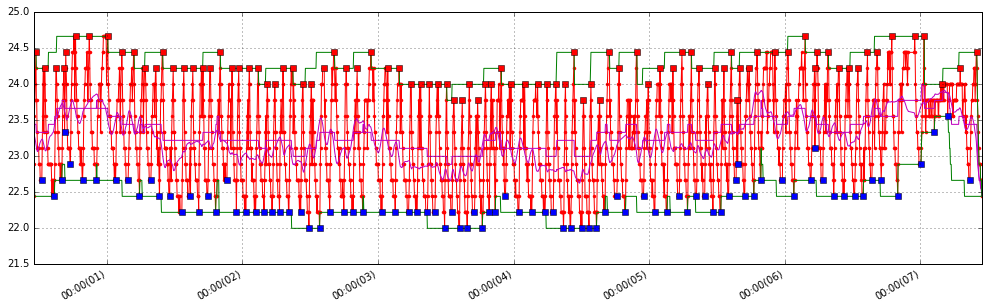

In [150]:
%matplotlib inline
import math
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.pyplot as plt
tli=df.t.tolist()
gli=df.g.tolist()
tout=df.a.tolist()
mn=min(gli)
#gli=[x-mn for x in gli]
g2=gli
mx=max(gli)
## limit for fast rise 0.3 deg
## limit peak detect is 40% of the range
#g2=[ j for j in gli ]
#g2on=[ 1 if (x/mx)>0.5 else 0  for x in gli ]  #green
#g2a=[ (i-j) if (i-j)>0.3 else 0 for i, j in zip(gli[:-1], gli[1:])]
#g3=[ math.ceil((j-mean)/mx) for i, j in zip(gli[:-1], gli[1:])]
av=[]
myavg=[]
mymax=[]
mymin=[]
mymean=[] 
for i in g2:
    av.append(i)
    if (len(av)>45):
        del( av[0] )
    myavg.append( sum(av) / float(len(av)) )
    mymax.append( max(av) )
    mymin.append( min(av) )
    mymean.append( (max(av)+min(av))/2 )
############# generate brackets hi lo none    
g2on=[]    
band=0.2   # band aroung mean 20%
for i in range(len(g2)):
    d=mymax[i]-mymin[i]
    mean=(mymean[i]+myavg[i])/2
    if (g2[i]> mean+d*band):
        g2on.append(+1)
    elif (g2[i]<mean-d*band):
        g2on.append(-1)
    else:
        g2on.append(0)

################## FIND max/min in the continuous +1 or -1 region
extremesH=[]
extremesL=[]  
smax=mn
smin=mx
for i in range( len(gli)):
    if ((g2on[i]>0.0)):
        if ( gli[i]>smax ):
            smax=gli[i]
            pair=( tli[i], gli[i] )
    if ((smax!=mn)and(g2on[i]<0)):
        extremesH.append( pair )
        #print('high',pair)
        smax=mn
smax=mn
smin=mx
for i in range( len(gli)):
    if ((g2on[i]<0.0)):
        if ( gli[i]<smin ):
            smin=gli[i]
            pair=( tli[i], gli[i] )
    if ((smin!=mx)and(g2on[i]>0)):
        extremesL.append( pair )
        #print('low',pair)
        smin=mx

#print(mx,0,'Nalezeno',smax,smin, extremes)        
        
monthsFmt = DateFormatter("%H:%M(%d)")
fig, ax = plt.subplots( figsize=(17, 5), dpi=100 )
ax.xaxis.set_major_formatter(monthsFmt)#nice diagonal format
plt.plot( df.t, g2 ,'r.-')
###plt.plot( df.t[1:], g2a ,'b.-')
###plt.plot( df.t[1:], g3 ,'g.:')
#plt.plot( df.t, g2on ,'y.')
plt.plot( df.t, myavg ,'m')
plt.plot( df.t, mymin ,'g')
plt.plot( df.t, mymean ,'m')  #BETTER than avg
plt.plot( df.t, mymax ,'g')
#plt.plot( df.t, tout ,'y')
plt.plot( *zip(*extremesH) , marker='s', color='r', ls='')
plt.plot( *zip(*extremesL) , marker='s', color='b', ls='')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.savefig('cerpadlo.jpg')
plt.show()

    Cold                                         Hot
(Timestamp('2016-12-31 12:28:07'), 22.6594) (Timestamp('2016-12-31 11:25:37'), 24.437)
(Timestamp('2016-12-31 14:41:27'), 22.4372) (Timestamp('2016-12-31 13:01:27'), 24.2148)
starts with Hot


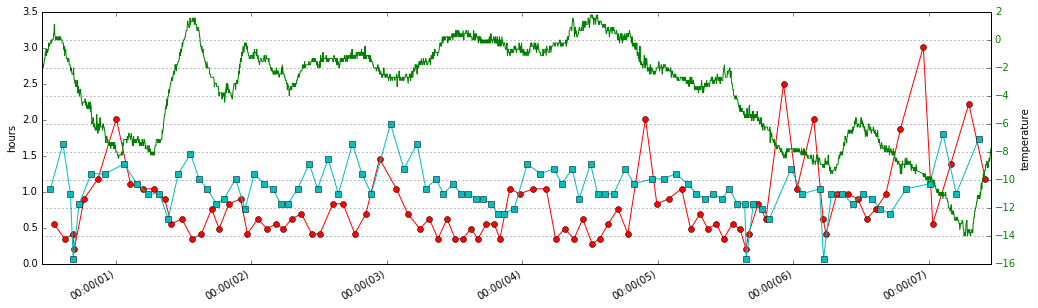

In [164]:
#print( len(extremesH) )  print( len(extremesL) )
print('    Cold                                         Hot')
print(   extremesL[-1], extremesH[-1] )   #pozadu
print(   extremesL[-2], extremesH[-2] )
#print(   extremesL)
#print( extremesH )
if (extremesL[-1]<extremesH[-1]):
    print('starts with Cold')
    cc=[  (c[0],(h[0]-c[0]).total_seconds()/3600) for h,c in zip( reversed(extremesH),reversed(extremesL)) ] 
    hh=[  (h[0],(c[0]-h[0]).total_seconds()/3600) for h,c in zip( reversed(extremesH[:-1]),reversed(extremesL)) ]
else:
    print('starts with Hot')
    cc=[  (c[0],(c[0]-h[0]).total_seconds()/3600) for h,c in zip( reversed(extremesH),reversed(extremesL))] 
    hh=[  (h[0],(h[0]-c[0]).total_seconds()/3600) for h,c in zip( reversed(extremesH[:-1]),reversed(extremesL)) ]
monthsFmt = DateFormatter("%H:%M(%d)")
fig2, ax2 = plt.subplots( figsize=(17, 5), dpi=100 )
ax2.xaxis.set_major_formatter(monthsFmt)#nice diagonal format

plt.plot( *zip(*hh)   , color='r' , marker='o',  ls='-')
plt.plot( *zip(*cc)   , color='c' , marker='s',  ls='-')
plt.ylabel('hours')

#plt.hist( hh , 30, color='b' , edgecolor="none" , range=[0,3]  )
#plt.hist( cc , 30  , color='r' , range=[0,3] , alpha=0.4  )

x1,x2,y1,y2 = plt.axis()
#plt.axis((x1,x2,-12,4.5))
ax2b=ax2.twinx()
ax2b.plot( df.t, tout ,'g')
plt.ylabel('temperature')
for tl in ax2b.get_yticklabels():
    tl.set_color('g')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.savefig('cerpadlo_deltaH.jpg')

plt.show()

This is comment
-----------------

- 1 
- oejoi    **www**    *rrrr*

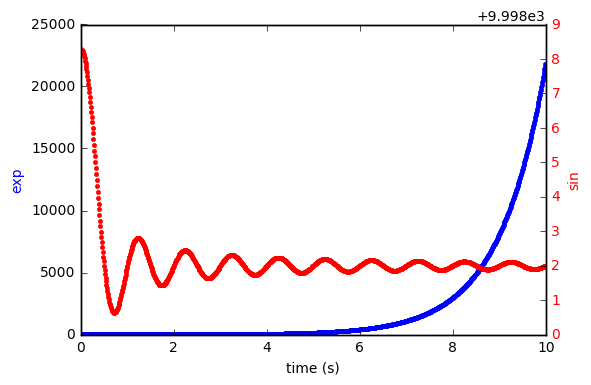

In [14]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)

s1 = np.exp(t)
ax1.plot(t, s1, 'b.-')
ax1.set_xlabel('time (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('exp', color='b')
#for tl in ax1.get_yticklabels():
#    tl.set_color('b')

ax2 = ax1.twinx()
s2 = np.sin(2*np.pi*t)/t+10000

ax2.plot(t, s2, 'r.')
ax2.set_ylabel('sin', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()